# GAN Development - Kochems Approach


## Import libraries

In [363]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import MinMaxScaler
import io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import csv
from collections import defaultdict
from data_reader import DataReader
from torch.autograd import Variable, grad
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

np.set_printoptions(threshold=np.inf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [364]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Read in Data

### Functions to preprocess data

In [365]:
def convert_ask_bid_int(dataset):
    mask_ask = np.char.endswith(dataset[:,:,2], 'ask')
    mask_bid = np.char.endswith(dataset[:,:,2], 'bid')
    dataset[:,:,2][mask_ask] = '1'
    dataset[:,:,2][mask_bid] = '0'
    dataset = dataset.astype(np.float32)
    return dataset
    
    
def get_dataset_max_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = 0
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2-(level))
    last_row_prices = dataset[:, index_on_each_OB, 0]
    max_val = np.max(last_row_prices)
    return max_val

def get_dataset_min_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = -1
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2+(level-1))
    first_row_prices = dataset[:, index_on_each_OB, 0]
    min_val = np.min(first_row_prices)
    return min_val

def make_histogram_from_dataset(dataset, rows_per_orderbook = 100, bin_width = 0.5, level = -1):
    X_train = []
    hist_max = get_dataset_max_price(dataset, rows_per_orderbook, level)
    hist_min = get_dataset_min_price(dataset, rows_per_orderbook, level)
    print("range: ", hist_min, " ", hist_max)
    num_bins = int(np.ceil((hist_max-hist_min) / bin_width))
    bins = np.linspace(hist_min, hist_max, num_bins)
    for i in range(len(dataset)):
        orderbook = dataset[i]
        price = orderbook[:,0]
        quantity = orderbook[:,1]
        quantity[orderbook[:, 2] == 0] *= -1
        hist, bin_edges = np.histogram(price, bins=bins, weights=quantity)
        X_train.append(hist)
    X_train = np.array(X_train)
    return X_train, hist_min, hist_max, bins

def make_centred_LOB_snapshots(histograms, level = 1):
    X_train = []
    y_train = []
    for i in range(len(histograms)-1):
        current_OB = histograms[i]
        next_OB = histograms[i+1]
        j = -1
        while j < len(current_OB)-1 and not (current_OB[j] < 0 and current_OB[j+1] > 0): j+=1
        j+=1
        
        current_start_index = j-level
        current_subarray_size = 2 * level
        current_centre_LOB_snapshot = current_OB[current_start_index: current_start_index + current_subarray_size]
        
        next_subarray_size = 2 * current_subarray_size
        next_centre_LOB_snapshot = next_OB[current_start_index - level: (current_start_index - level) + next_subarray_size]
        
        if np.any(next_centre_LOB_snapshot == 0):
            continue
        
        X_train.append(current_centre_LOB_snapshot)
        y_train.append(next_centre_LOB_snapshot)
    
    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    
    return X_train, y_train
        
def normalization(X_train, c=8):
    sqrt_abs_over_c = np.sqrt(np.abs(X_train)) / c
    with_sign = np.sign(X_train) * sqrt_abs_over_c
    return with_sign

def get_centre_of_LOB(X_t_delta_t, level=3):
    index = -1
    for i in range(len(X_t_delta_t)-1):
        if X_t_delta_t[i] < 0 and X_t_delta_t[i+1]>0: index = i+1
    return X_t_delta_t[(index-level): (index-level) + 2 * level]    

### Functions to post-process data

In [366]:
def reverse_normalization(X_train_normalized, c=8):
    if not isinstance(X_train_normalized, np.ndarray) and X_train_normalized.device.type == 'cuda':
        X_train_normalized = X_train_normalized.cpu()
    unscaled_data = X_train_normalized * c
    X_train = np.sign(X_train_normalized) * (unscaled_data ** 2)
    return X_train
    

### Actually reading in data

In [367]:
data_reader = DataReader("orderbook_snapshots.csv", rows_per_orderbook=100)
data_reader.read_csv()
X_train_raw = data_reader.get_data()
X_train_raw = convert_ask_bid_int(X_train_raw)

print(X_train_raw.shape)

(24283, 100, 3)


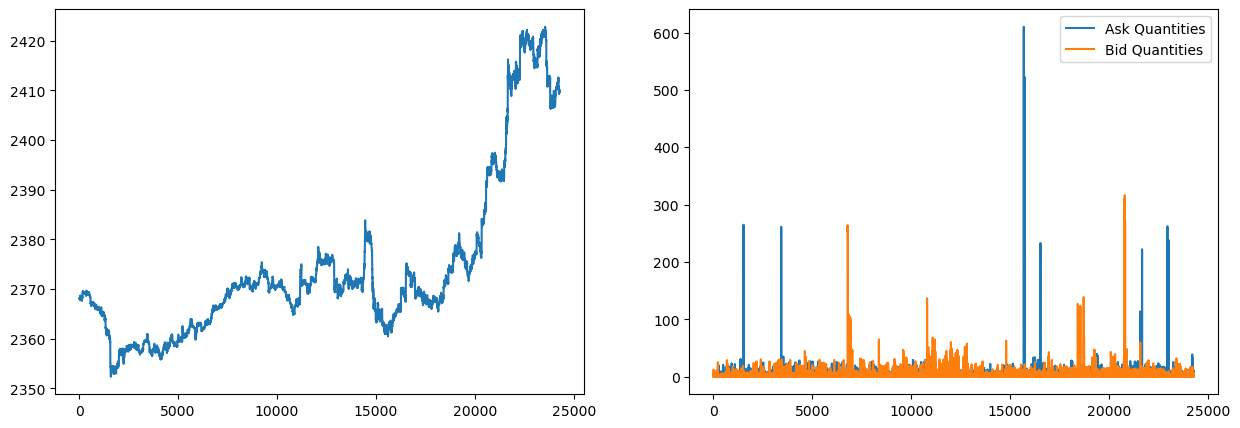

In [368]:
best_prices = (X_train_raw[:, 49, 0] + X_train_raw[:, 50, 0]) /2
best_ask_quantities = X_train_raw[:, 49, 1]
best_bid_quantities = np.abs(X_train_raw[:, 50, 1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(best_prices, label='Prices')
axes[1].plot(best_ask_quantities, label='Ask Quantities')
axes[1].plot(best_bid_quantities, label='Bid Quantities')
plt.legend()
plt.show()

### Preprocess data

In [369]:
histograms, price_min, price_max, bins = make_histogram_from_dataset(X_train_raw, rows_per_orderbook=100, bin_width=0.5, level=-1)
print(histograms.shape)
# print(X_train_raw)

range:  2346.7   2428.5
(24283, 163)


### Non-Marginal Histogram of all Orderbook States

(24213, 6)   (24213, 12)
[-162.17346   -81.77905   -25.47998    30.691528   54.218994  161.84149 ]
[ -66.15094  -102.86188  -107.099    -135.7185    -61.813477  -23.772583
   30.078125   82.77966   140.59637   244.19019    37.10547    14.409119]


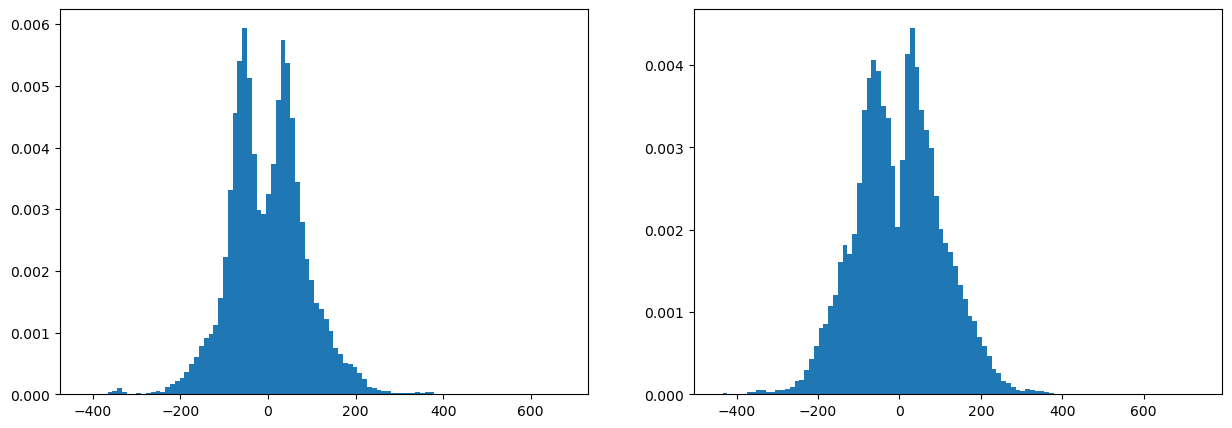

(24213, 6)   (24213, 12)
[-1.5918418  -1.1303972  -0.63097125  0.6924992   0.92041934  1.5902117 ]
[-1.0166653  -1.2677605  -1.2936081  -1.4562286  -0.9827693  -0.6094642
  0.6855441   1.1372917   1.4821668   1.9533232   0.76142824  0.4744918 ]


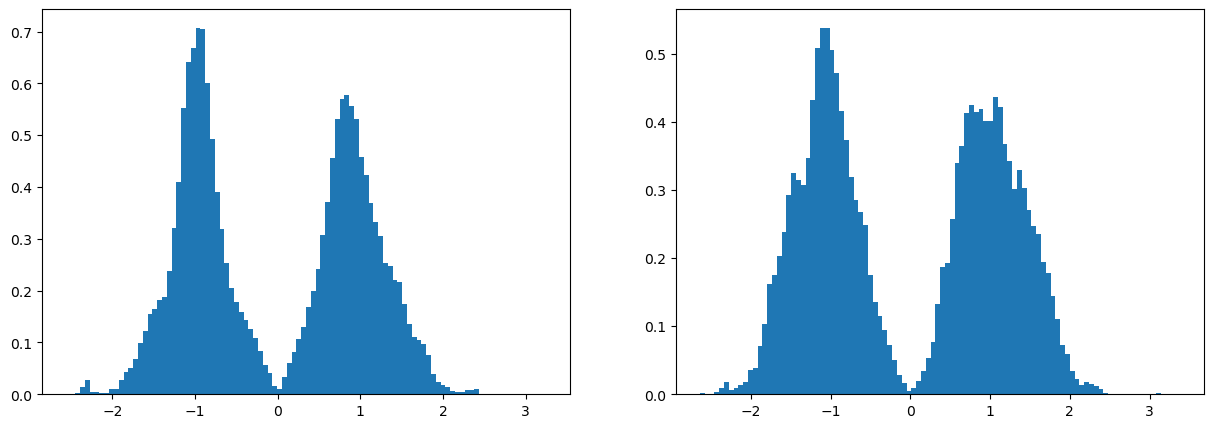

In [370]:
X_train_not_processed, y_train_not_processed = make_centred_LOB_snapshots(histograms, level=3)
print(X_train_not_processed.shape," ",y_train_not_processed.shape)
print(X_train_not_processed[0])
print(y_train_not_processed[0])
all_orders = X_train_not_processed.ravel()
all_orders_next = y_train_not_processed.ravel()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(all_orders, bins=100, density=True)
axes[1].hist(all_orders_next, bins=100, density=True)

plt.show()

S_t_dataset = normalization(X_train=X_train_not_processed,c=8)
X_t_delta_t_dataset = normalization(X_train=y_train_not_processed,c=8)
print(S_t_dataset.shape," ", X_t_delta_t_dataset.shape)
print(S_t_dataset[0])
print(X_t_delta_t_dataset[0])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(S_t_dataset.ravel(), bins=100, density=True)
axes[1].hist(X_t_delta_t_dataset.ravel(), bins=100, density=True)

plt.show()

### Marginal Distributions (Normalized)

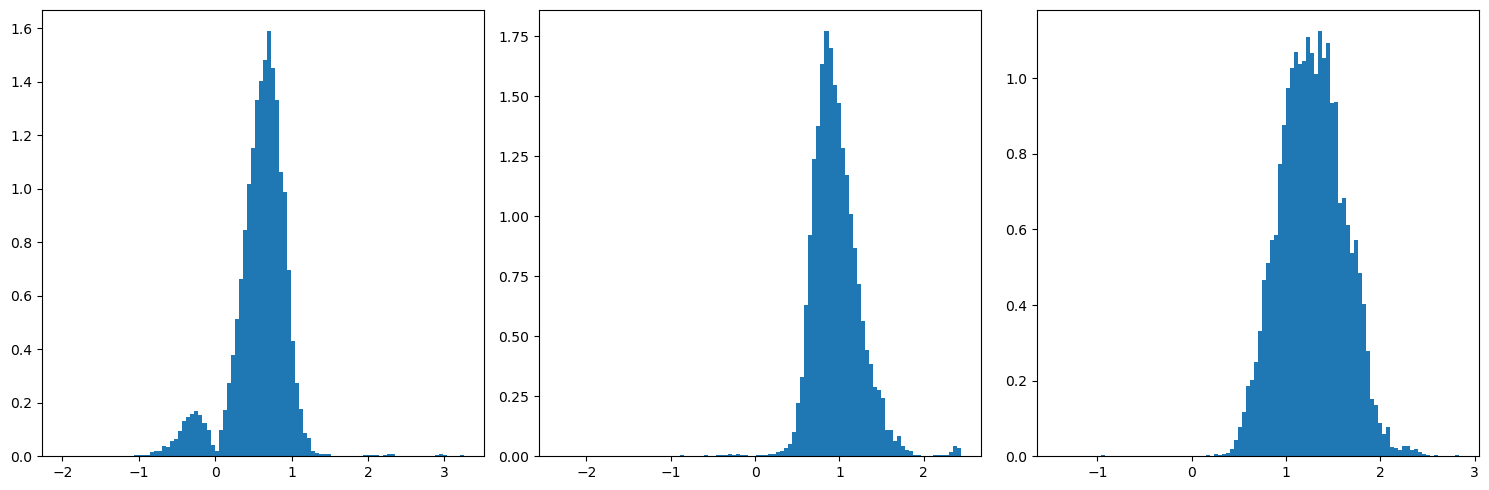

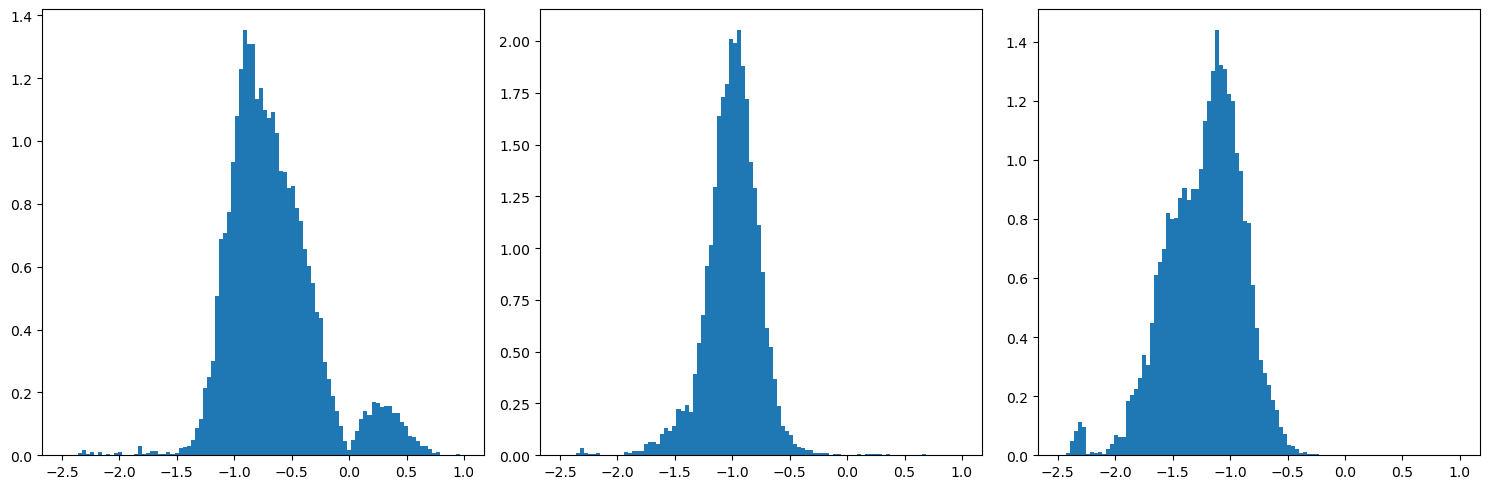

In [371]:
asks_1 = X_t_delta_t_dataset[:, 6]
asks_2 = X_t_delta_t_dataset[:, 7]
asks_3 = X_t_delta_t_dataset[:, 8]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(asks_1, bins=100, density=True)
axes[1].hist(asks_2, bins=100, density=True)
axes[2].hist(asks_3, bins=100, density=True)

plt.tight_layout()
plt.show()

bids_1 = X_t_delta_t_dataset[:, 5]
bids_2 = X_t_delta_t_dataset[:, 4]
bids_3 = X_t_delta_t_dataset[:, 3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(bids_1, bins=100, density=True, range=(-2.5,1))
axes[1].hist(bids_2, bins=100, density=True, range=(-2.5,1))
axes[2].hist(bids_3, bins=100, density=True, range=(-2.5,1))

plt.tight_layout()
plt.show()

[-1.2194207  -1.0050904  -0.7060585   0.6256231   0.97079974  1.274186  ]


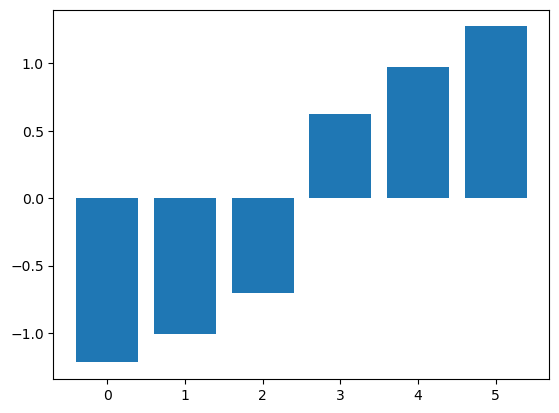

In [372]:
mean_LOB_shape = np.mean(S_t_dataset, axis=0)
print(mean_LOB_shape)
indices = np.arange(len(mean_LOB_shape))
plt.bar(indices, mean_LOB_shape)
plt.show()

In [373]:
S_t_dataset_tensor = torch.tensor(S_t_dataset, dtype=torch.float32).to(device)
X_t_delta_t_dataset_tensor = torch.tensor(X_t_delta_t_dataset, dtype=torch.float32).to(device)
dataset = TensorDataset(X_t_delta_t_dataset_tensor, S_t_dataset_tensor)
data_loader = DataLoader(dataset, batch_size=500, shuffle=True)

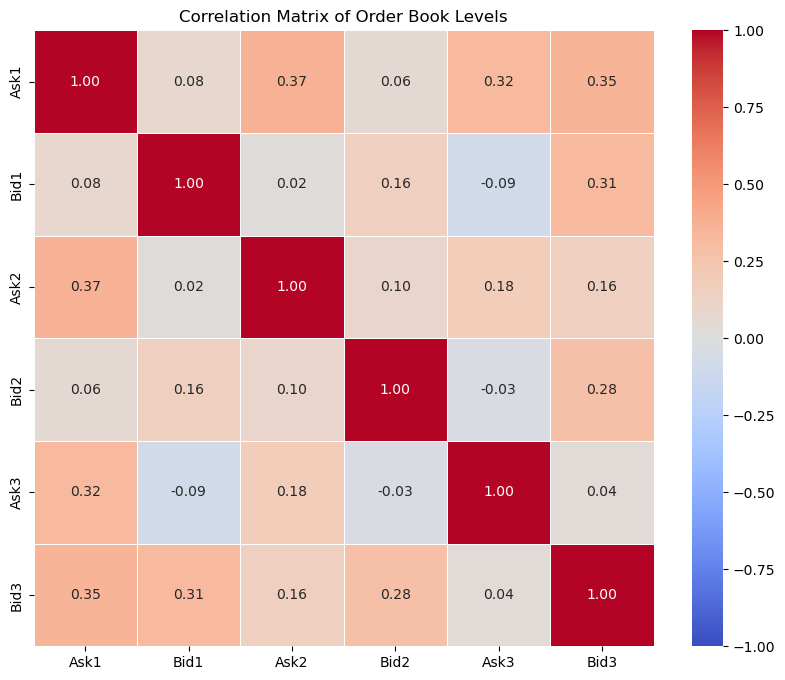

In [374]:
import numpy as np
import pandas as pd

# First, select the relevant slices of the array for bid_1, bid_2, bid_3, ask_1, ask_2, and ask_3
data = X_t_delta_t_dataset[:, [6, 3, 7, 4, 8, 5]]

# Convert this data into a pandas DataFrame
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(data, columns=columns)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Order Book Levels')
plt.show()


## WGAN-GP Training

### Defining the Critic and Generator

In [375]:
class Generator(nn.Module):
    def __init__(self, latent_dim=6, n=6):
        super(Generator, self).__init__()
        self.h_11 = nn.Linear(latent_dim,32).to(device)
        self.h_12 = nn.Linear(n,32).to(device)
        self.h_21 = nn.Linear(32,32).to(device)
        self.h_22 = nn.Linear(32,32).to(device)
        self.h_32 = nn.Linear(64, 64).to(device)
        self.h_33 = nn.Linear(64, 12).to(device)

    def forward(self, Z_t, S_t):
        Z_t = Z_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(Z_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))
        
        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)
        
        h_32_output = torch.relu(self.h_32(h_31_output))
        h_33_output = self.h_33(h_32_output)
        return h_33_output

'''
# Markovian Setting
class Critic(nn.Module):
    def __init__(self, n_1=12, n_2=6):
        super(Critic, self).__init__()
        self.h_11 = nn.Linear(n_1,32).to(device)
        self.h_12 = nn.Linear(n_2,32).to(device)
        self.h_21 = nn.Linear(32,32).to(device)
        self.h_22 = nn.Linear(32,32).to(device)
        self.h_32 = nn.Linear(64, 64).to(device)
        self.h_33 = nn.Linear(64, 1).to(device)

    def forward(self, X_t_delta_t, S_t):
        X_t_delta_t = X_t_delta_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(X_t_delta_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))
        
        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)
        
        h_32_output = torch.relu(self.h_32(h_31_output))
        h_33_output = self.h_33(h_32_output)
        return h_33_output
'''


class Critic(nn.Module):
    def __init__(self, n_1=12, n_2=6):
        super(Critic, self).__init__()
        # Increasing the depth and width of the network
        self.model = nn.Sequential(
            nn.Linear(n_1 + n_2, 64).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Linear(64, 128).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Linear(128, 256).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Dropout(0.3).to(device),
            nn.Linear(256, 1).to(device)
        )

    def forward(self, X_t_delta_t, S_t):
        X_t_delta_t = X_t_delta_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device        
        # Concatenation of inputs
        combined_input = torch.cat((X_t_delta_t, S_t), dim=1)
        validity = self.model(combined_input)
        return validity


In [376]:
# Define training hyperparameters
n_critic = 5
z_t_dim = 6
LAMBDA = 10
epochs = 10000

# Instantiate the generator and discriminator with device adaptation
generator = Generator(latent_dim=z_t_dim, n=6).to(device)
critic = Critic(n_1=12, n_2=6).to(device)

# Define the optimisers
optimizer_G = optim.Adam(generator.parameters(), lr=0.00001, betas=(0, 0.9))
optimizer_D = optim.Adam(critic.parameters(), lr=0.00001, betas=(0, 0.9))

avg_d_loss_list = []
avg_g_loss_list = []

### Defining the training loop

#### Tensorboard functions

In [377]:
# Initialize SummaryWriter
writelocation = "runs/" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
writer = SummaryWriter(writelocation)

# def write_marginal_distributions_to_tensorboard(epoch):
#     # Generate 100 plausible (not conditional) order book snapshots
#     with torch.no_grad():
#         z_t = torch.randn(S_t_dataset.shape[0], z_t_dim)
#         X_t_delta_t_generated = generator(z_t, S_t_dataset_tensor) 
#         plausible_generated_snaps = X_t_delta_t_generated

#     # Note: Adjust the indices for ask_1, ask_2, ask_3 if needed based on your dataset's structure
#     ask_1 = plausible_generated_snaps[:, 6]
#     ask_2 = plausible_generated_snaps[:, 7]
#     ask_3 = plausible_generated_snaps[:, 8]

#     # Log histograms to TensorBoard instead of plotting
#     writer.add_histogram('MD/Ask 1', ask_1, epoch)
#     writer.add_histogram('MD/Ask 2', ask_2, epoch)
#     writer.add_histogram('MD/Ask 3', ask_3, epoch)

#     # Note: Adjust the indices for ask_1, ask_2, ask_3 if needed based on your dataset's structure
#     bid_1 = plausible_generated_snaps[:, 3]
#     bid_2 = plausible_generated_snaps[:, 4]
#     bid_3 = plausible_generated_snaps[:, 5]
    
#         # Log histograms to TensorBoard instead of plotting
#     writer.add_histogram('MD/Bid 1', bid_1, epoch)
#     writer.add_histogram('MD/Bid 2', bid_2, epoch)
#     writer.add_histogram('MD/Bid 3', bid_3, epoch)
    
def write_marginal_distributions_to_tensorboard(epoch):
    # Generate 100 plausible (not conditional) order book snapshots
    with torch.no_grad():
        z_t = torch.randn(S_t_dataset.shape[0], z_t_dim)
        X_t_delta_t_generated = generator(z_t, S_t_dataset_tensor)
        plausible_generated_snaps = X_t_delta_t_generated

    # Function to create and log a KDE plot
    def log_kde_plot(data, title, epoch, writer):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data.cpu().numpy(), fill=True)
        plt.title(title)
        # Save the plot to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        # Use add_image to log the plot
        writer.add_image(title, plt.imread(buf), epoch, dataformats='HWC')

    # Indices for asks and bids might need adjustment based on dataset structure
    asks_bids_indices = {
        'MD/Ask 1': 6,
        'MD/Ask 2': 7,
        'MD/Ask 3': 8,
        'MD/Bid 1': 3,
        'MD/Bid 2': 4,
        'MD/Bid 3': 5,
    }

    for title, index in asks_bids_indices.items():
        data = plausible_generated_snaps[:, index]
        log_kde_plot(data, title, epoch, writer)    
        
def write_loss_functions_to_tensorboard(avg_d_loss, avg_g_loss,epoch):
    writer.add_scalar('Loss/Discriminator', avg_d_loss, epoch)
    writer.add_scalar('Loss/Generator', avg_g_loss, epoch)

#### Gradient Penalty

In [378]:
def gradient_penalty(C, real_samples, fake_samples, batch_S_t):
    batch_size = real_samples.size(0)
    # Ensure alpha is shaped correctly for broadcasting
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand(batch_size, real_samples.nelement() // batch_size).contiguous().view(batch_size, -1)

    # Calculate interpolates
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = C(interpolates, batch_S_t)
    
    fake = Variable(torch.Tensor(batch_size , 1).fill_(1.0), requires_grad=False).to(device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Flatten the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

#### Training Loop of WGAN with Gradient Penalty

In [379]:
# Define variables to track progress
avg_d_loss = 0
avg_g_loss = 0
n_batches = len(data_loader)

for epoch in range(epochs):
    
    # Variables per epoch
    total_d_loss_epoch = 0
    total_g_loss_epoch = 0
    
    for i, (batch_X_t_delta_t, batch_S_t) in enumerate(data_loader):
        batch_size = batch_S_t.shape[0]
        
        batch_S_t = batch_S_t.to(device)
        batch_X_t_delta_t = batch_X_t_delta_t.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        total_d_loss_batch = 0
        for _ in range(n_critic):  # Update the discriminator n_critic times
            optimizer_D.zero_grad()

            # Sample noise as generator input
            batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)  # Ensure noise_dim matches generator input

            # Generate a batch of images
            batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)

            # Real images
            real_validity = critic(batch_X_t_delta_t, batch_S_t)
            # Fake images
            fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
            # Gradient penalty
            gp = gradient_penalty(critic, batch_X_t_delta_t.data, batch_X_t_delta_t_generated.data, batch_S_t.data)
            
            # Wasserstein GAN loss w/ gradient penalty
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA * gp

            d_loss.backward()
            optimizer_D.step()
            total_d_loss_batch += d_loss.item()
            
        d_loss_batch = total_d_loss_batch / n_critic
        total_d_loss_epoch += d_loss_batch # Average over the n_critic updates
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Resample noise (optional but often leads to better training stability)
        batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)

        # Generate a batch of images
        batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)
        fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
        # Loss measures generator's ability to fool the discriminator
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()
        total_g_loss_epoch += g_loss.item()

        # Prints progress within the epoch
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f"\tEpoch [{epoch+1}/{epochs}], Step [{i+1}/{n_batches}], D Loss: {d_loss_batch:.4f}, G Loss: {g_loss.item():.4f}")
    
    # Prints average loss per epoch
    avg_d_loss = total_d_loss_epoch / n_batches
    avg_g_loss = total_g_loss_epoch / n_batches
    avg_d_loss_list.append(avg_d_loss)
    avg_g_loss_list.append(avg_g_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] completed. Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        
    if (epoch + 1) % 100 == 0:
        write_marginal_distributions_to_tensorboard(epoch)
        
    write_loss_functions_to_tensorboard(avg_d_loss, avg_g_loss,epoch)
    # Resets average losses for the next epoch
    avg_d_loss = 0
    avg_g_loss = 0

# Close the writer after the training loop
writer.close()    

Epoch [20/10000] completed. Avg D Loss: -3.7576, Avg G Loss: -0.1170
Epoch [40/10000] completed. Avg D Loss: -2.9610, Avg G Loss: -0.2538
Epoch [60/10000] completed. Avg D Loss: -1.5569, Avg G Loss: -0.0588
Epoch [80/10000] completed. Avg D Loss: -0.8867, Avg G Loss: 1.6398
Epoch [100/10000] completed. Avg D Loss: -0.8990, Avg G Loss: 1.1684
Epoch [120/10000] completed. Avg D Loss: -0.7931, Avg G Loss: 1.0258
Epoch [140/10000] completed. Avg D Loss: -0.7124, Avg G Loss: 1.2694
Epoch [160/10000] completed. Avg D Loss: -0.6321, Avg G Loss: 1.3995
Epoch [180/10000] completed. Avg D Loss: -0.5314, Avg G Loss: 1.9054
Epoch [200/10000] completed. Avg D Loss: -0.4340, Avg G Loss: 4.2849
Epoch [220/10000] completed. Avg D Loss: -0.4003, Avg G Loss: 4.1680
Epoch [240/10000] completed. Avg D Loss: -0.3593, Avg G Loss: 4.6158
Epoch [260/10000] completed. Avg D Loss: -0.3192, Avg G Loss: 4.7350
Epoch [280/10000] completed. Avg D Loss: -0.2446, Avg G Loss: 4.6401
Epoch [300/10000] completed. Avg D 

Epoch [2400/10000] completed. Avg D Loss: -0.1101, Avg G Loss: 2.5533
Epoch [2420/10000] completed. Avg D Loss: -0.0490, Avg G Loss: 2.0653
Epoch [2440/10000] completed. Avg D Loss: -0.0272, Avg G Loss: 2.4520
Epoch [2460/10000] completed. Avg D Loss: -0.0315, Avg G Loss: 2.4605
Epoch [2480/10000] completed. Avg D Loss: -0.0358, Avg G Loss: 2.1848
Epoch [2500/10000] completed. Avg D Loss: -0.0267, Avg G Loss: 1.9986
Epoch [2520/10000] completed. Avg D Loss: -0.0426, Avg G Loss: 2.1108
Epoch [2540/10000] completed. Avg D Loss: -0.0288, Avg G Loss: 2.1574
Epoch [2560/10000] completed. Avg D Loss: -0.0355, Avg G Loss: 1.9884
Epoch [2580/10000] completed. Avg D Loss: -0.0318, Avg G Loss: 1.6990
Epoch [2600/10000] completed. Avg D Loss: -0.0354, Avg G Loss: 1.3409
Epoch [2620/10000] completed. Avg D Loss: -0.0423, Avg G Loss: 1.1072
Epoch [2640/10000] completed. Avg D Loss: -0.0469, Avg G Loss: 0.8384
Epoch [2660/10000] completed. Avg D Loss: -0.0463, Avg G Loss: 1.0534
Epoch [2680/10000] c

Epoch [4760/10000] completed. Avg D Loss: -0.0783, Avg G Loss: 5.4327
Epoch [4780/10000] completed. Avg D Loss: -0.0751, Avg G Loss: 5.4818
Epoch [4800/10000] completed. Avg D Loss: -0.0749, Avg G Loss: 5.4386
Epoch [4820/10000] completed. Avg D Loss: -0.0798, Avg G Loss: 5.4270
Epoch [4840/10000] completed. Avg D Loss: -0.0830, Avg G Loss: 5.4472
Epoch [4860/10000] completed. Avg D Loss: -0.0830, Avg G Loss: 5.3491
Epoch [4880/10000] completed. Avg D Loss: -0.0810, Avg G Loss: 5.1488
Epoch [4900/10000] completed. Avg D Loss: -0.0806, Avg G Loss: 5.0914
Epoch [4920/10000] completed. Avg D Loss: -0.0826, Avg G Loss: 5.0465
Epoch [4940/10000] completed. Avg D Loss: -0.0794, Avg G Loss: 4.9928
Epoch [4960/10000] completed. Avg D Loss: -0.0802, Avg G Loss: 4.9213
Epoch [4980/10000] completed. Avg D Loss: -0.0813, Avg G Loss: 4.7756
Epoch [5000/10000] completed. Avg D Loss: -0.0787, Avg G Loss: 4.6971
Epoch [5020/10000] completed. Avg D Loss: -0.0836, Avg G Loss: 4.5678
Epoch [5040/10000] c

Epoch [7120/10000] completed. Avg D Loss: -0.0803, Avg G Loss: 2.6331
Epoch [7140/10000] completed. Avg D Loss: -0.0761, Avg G Loss: 2.7285
Epoch [7160/10000] completed. Avg D Loss: -0.0761, Avg G Loss: 2.7676
Epoch [7180/10000] completed. Avg D Loss: -0.0761, Avg G Loss: 2.8029
Epoch [7200/10000] completed. Avg D Loss: -0.0765, Avg G Loss: 2.9047
Epoch [7220/10000] completed. Avg D Loss: -0.0763, Avg G Loss: 3.0252
Epoch [7240/10000] completed. Avg D Loss: -0.0768, Avg G Loss: 3.0797
Epoch [7260/10000] completed. Avg D Loss: -0.0761, Avg G Loss: 3.1015
Epoch [7280/10000] completed. Avg D Loss: -0.0758, Avg G Loss: 3.0787
Epoch [7300/10000] completed. Avg D Loss: -0.0782, Avg G Loss: 3.1163
Epoch [7320/10000] completed. Avg D Loss: -0.0783, Avg G Loss: 3.2532
Epoch [7340/10000] completed. Avg D Loss: -0.0795, Avg G Loss: 3.2008
Epoch [7360/10000] completed. Avg D Loss: -0.0798, Avg G Loss: 3.2742
Epoch [7380/10000] completed. Avg D Loss: -0.0783, Avg G Loss: 3.3189
Epoch [7400/10000] c

Epoch [9480/10000] completed. Avg D Loss: -0.0857, Avg G Loss: 3.3855
Epoch [9500/10000] completed. Avg D Loss: -0.0862, Avg G Loss: 3.4538
Epoch [9520/10000] completed. Avg D Loss: -0.0870, Avg G Loss: 3.5575
Epoch [9540/10000] completed. Avg D Loss: -0.0698, Avg G Loss: 3.5297
Epoch [9560/10000] completed. Avg D Loss: -0.0666, Avg G Loss: 3.2697
Epoch [9580/10000] completed. Avg D Loss: -0.1294, Avg G Loss: 3.5762
Epoch [9600/10000] completed. Avg D Loss: -0.0511, Avg G Loss: 3.4051
Epoch [9620/10000] completed. Avg D Loss: -0.1048, Avg G Loss: 3.5175
Epoch [9640/10000] completed. Avg D Loss: -0.1388, Avg G Loss: 3.6442
Epoch [9660/10000] completed. Avg D Loss: -0.0740, Avg G Loss: 4.1215
Epoch [9680/10000] completed. Avg D Loss: -0.1271, Avg G Loss: 3.8546
Epoch [9700/10000] completed. Avg D Loss: -0.1228, Avg G Loss: 3.9062
Epoch [9720/10000] completed. Avg D Loss: -0.1334, Avg G Loss: 4.1046
Epoch [9740/10000] completed. Avg D Loss: -0.0590, Avg G Loss: 4.2477
Epoch [9760/10000] c

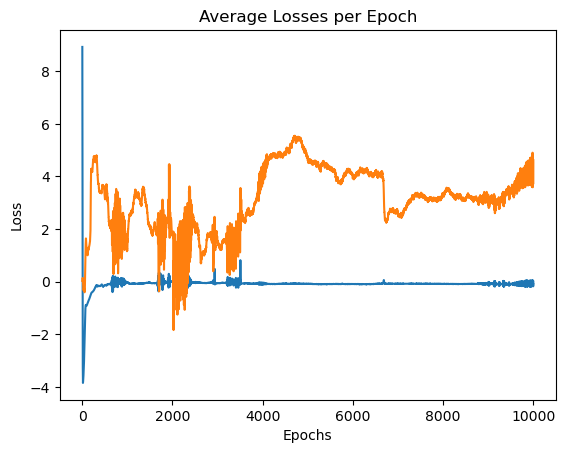

In [380]:
def plot_losses(avg_d_loss_list, avg_g_loss_list):
    epochs = range(1, len(avg_d_loss_list) + 1)
    plt.plot(epochs, avg_d_loss_list, label='Discriminator Loss')
    plt.plot(epochs, avg_g_loss_list, label='Generator Loss')
    plt.title('Average Losses per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')        
    plt.grid(False)
    plt.show()

# Now, call the function with your lists
plot_losses(avg_d_loss_list, avg_g_loss_list)

6. Save Generator Model

In [381]:
# Save the generator's state dictionary
torch.save(generator.state_dict(), '/Users/sina/Downloads/SCRATCH_GENERATIVE_ADV_NET/Saved_Generator_States/generator_state_dict_1000epochs.pth')
print("Generator state has been saved.")

RuntimeError: Parent directory /Users/sina/Downloads/SCRATCH_GENERATIVE_ADV_NET/Saved_Generator_States does not exist.

7. Generate Example Orderbook Snapshots

In [ ]:
# Generate a sample order book snapshot
i=0
counter = 0
while (True):
    with torch.no_grad():
        if counter == 1: break
        i += 1
        z_t = torch.randn(1,z_t_dim)
        s_t = torch.tensor(S_t_dataset[0], dtype=torch.float32).unsqueeze(0)
        X_t_delta_t_example = generator(z_t, s_t)
        if reverse_normalization(X_t_delta_t_example)[0, 5] > 0 or reverse_normalization(X_t_delta_t_example)[0, 6] < 0:
            print(i)
            print("Current Order Book Snapshot:\t", reverse_normalization(s_t))
            print("Generated Order Book Snapshot:\t", reverse_normalization(X_t_delta_t_example))
            counter += 1
            
    
